## Programming Assignment 3 – Recurrent Neural Network

### Rajat Bishnoi, Shivam Bang, Rishabh Das, Likitha Reddy, Anil Kumar, Girish Mallya

In [102]:
import numpy as np
import random 
from numpy import genfromtxt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

### Step 1 - Design and build a dataset for RNN model

In [103]:
# Read s&p500 price data and schiller pe data.
price_new2 = pd.read_csv("HistoricalData2021.csv")
price_new1 = pd.read_csv('HistoricalPrices.csv')
price_old = pd.read_csv('HistoricalPrices_old.csv')
pe_ratio = pd.read_csv('ie_data_PE_full.csv')

In [104]:
# Note that the P/E ratio is monthly data 
pe_ratio = pe_ratio.rename({'Date':'Date_PE'},axis=1)
pe_ratio.head()

,Date_PE,PE_CAPE
0,1960.01,18.338285
1,1960.02,17.545275
2,1960.03,17.286021
3,1960.04,17.429767
4,1960.05,17.256171


In [105]:
price_old = price_old.drop(['Volume', 'Adj Close' ], 1)

# transform Date to date timestamp
price_old['Date'] = pd.to_datetime(price_old['Date'])
price_old = price_old.loc[ (price_old['Date'] < '1978-01-03') &  (price_old['Date']  >= '1960-01-01' )]
price_old.head()

,Date,Open,High,Low,Close
2511,1960-01-04,59.910000,59.910000,59.910000,59.910000
2512,1960-01-05,60.389999,60.389999,60.389999,60.389999
2513,1960-01-06,60.130001,60.130001,60.130001,60.130001
2514,1960-01-07,59.689999,59.689999,59.689999,59.689999
2515,1960-01-08,59.500000,59.500000,59.500000,59.500000


In [106]:
price_new1['Date'] = pd.to_datetime(price_new1['Date'])

#reverse the dataset
price_new1 = price_new1.iloc[::-1].reset_index(drop = True)
price_new1. columns = ['Date', 'Open', 'High', 'Low', 'Close']
price_new1.head()

,Date,Open,High,Low,Close
0,1978-01-03,93.82,95.15,93.49,93.82
1,1978-01-04,93.52,94.10,93.16,93.52
2,1978-01-05,92.74,94.53,92.51,92.74
3,1978-01-06,91.62,92.66,91.05,91.62
4,1978-01-09,90.64,91.52,90.01,90.64


In [107]:
price_new2['Date'] = pd.to_datetime(price_new2['Date'])

#reverse the dataset
price_new2 = price_new2.iloc[::-1].reset_index(drop = True)
price_new2. columns = ['Date', 'Open', 'High', 'Low', 'Close']
price_new2.head()

,Date,Open,High,Low,Close
0,2021-01-04,3764.61,3769.99,3662.71,3700.65
1,2021-01-05,3698.02,3737.83,3695.07,3726.86
2,2021-01-06,3712.20,3783.04,3705.34,3748.14
3,2021-01-07,3764.71,3811.55,3764.71,3803.79
4,2021-01-08,3815.05,3826.69,3783.60,3824.68


In [108]:
frames1 = [price_old, price_new1]
price_init = pd.concat(frames1).reset_index(drop = True)
price_init.head()

,Date,Open,High,Low,Close
0,1960-01-04,59.910000,59.910000,59.910000,59.910000
1,1960-01-05,60.389999,60.389999,60.389999,60.389999
2,1960-01-06,60.130001,60.130001,60.130001,60.130001
3,1960-01-07,59.689999,59.689999,59.689999,59.689999
4,1960-01-08,59.500000,59.500000,59.500000,59.500000


In [109]:
frames2 = [price_init, price_new2]
price = pd.concat(frames2).reset_index(drop = True)
price.head()

,Date,Open,High,Low,Close
0,1960-01-04,59.910000,59.910000,59.910000,59.910000
1,1960-01-05,60.389999,60.389999,60.389999,60.389999
2,1960-01-06,60.130001,60.130001,60.130001,60.130001
3,1960-01-07,59.689999,59.689999,59.689999,59.689999
4,1960-01-08,59.500000,59.500000,59.500000,59.500000


In [110]:
price['Date_PE']=0.0
for i in range(price.shape[0]):
    month = price['Date'][i].month
    year = price['Date'][i].year
    price.loc[i, 'Date_PE']=year+month*0.01
    
# merging sp500 data with the Schiller P/E ratio based on Date.
data = pd.merge(price, pe, how='left', on='Date_PE')
data = data.drop(['Date_PE' ], 1)

In [111]:
# save the merged dataset
data.to_csv('Price_PE_final.csv')

In [113]:
data.head()

,Date,Open,High,Low,Close,PE_CAPE
0,1960-01-04,59.910000,59.910000,59.910000,59.910000,18.338285
1,1960-01-05,60.389999,60.389999,60.389999,60.389999,18.338285
2,1960-01-06,60.130001,60.130001,60.130001,60.130001,18.338285
3,1960-01-07,59.689999,59.689999,59.689999,59.689999,18.338285
4,1960-01-08,59.500000,59.500000,59.500000,59.500000,18.338285


### Make an overlay of the Schiller P/E onto the S&P500 for the same period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


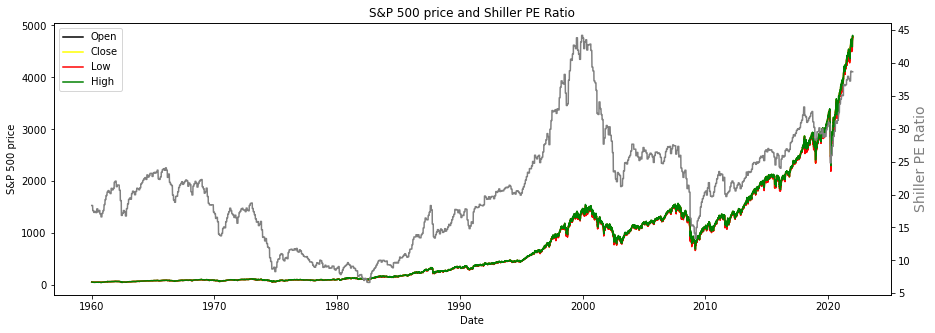

In [118]:
plt.figure(figsize=(15, 5));
plt.plot(data.Date, data.Open.values, color='black', label='Open')
plt.plot(data.Date, data.Close.values, color='yellow', label='Close')
plt.plot(data.Date, data.Low.values, color='red', label='Low')
plt.plot(data.Date, data.High.values, color='green', label='High')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
ax2=plt.twinx()
ax2.plot(data.Date, data.PE_CAPE.values,color="grey")
ax2.set_ylabel("Shiller PE Ratio", color="grey",fontsize=14)
plt.savefig('price_pe.eps')
plt.show()


#### We are only using Close price to train the model

In [119]:
dataset = data[['Close']].values
dataset

array([[  59.91    ],
       [  60.389999],
       [  60.130001],
       ...,
       [4793.06    ],
       [4778.73    ],
       [4766.18    ]])

In [121]:
# extracting the timestamp data
date_dt= data[ ['Date']].values

In [122]:
# min-max normalization of features
scaler = MinMaxScaler(feature_range = (0, 1))
dataset_normalized = scaler.fit_transform(dataset)
dataset_normalized

array([[0.00162629],
       [0.00172753],
       [0.00167269],
       ...,
       [1.        ],
       [0.99697734],
       [0.99433014]])

In [124]:
input_size = 1

# output_size = 4 as we want to predict the next one, two, three, and four trading data 
output_size = 4

# sequence length is 180
sliding_wd_size = 180

In [125]:
# Creating a data structure with 180 timesteps and 4 output
X = []
y = []
date_full = []
for i in range( n_rows - sliding_wd_size - output_size +1):
    X.append(dataset_normalized[i:i+sliding_wd_size, ])
    y.append(dataset_normalized[i+sliding_wd_size: i+ sliding_wd_size + output_size, 0])
    date_full.append(date_dt[i+sliding_wd_size])
    
X, y, date_full = np.array(X), np.array(y), np.array(date_full)
y = np.reshape(y, (y.shape[0], 1, y.shape[1]))

In [126]:
X.shape

(15423, 180, 1)

In [127]:
y.shape

(15423, 1, 4)

#### The NYSE and NASDAQ average about 253 trading days a year. We use 20% for testing, i.e. first 200 days for training, and consecutive 53 datapoints for testing.

#### Also, splitting the training dataset to smaller training dataset (80%) and validation set (20%) to determine the optimal number of epochs.

In [128]:
X_tr = []; y_tr = []; date_tr = []
X_val = []; y_val = []; date_val = []
X_tt = []; y_tt = []; date_tt = []
for i in range(X.shape[0]):
    if(i  %  253 >= 200):
        X_tt.append(X[i])
        y_tt.append(y[i])
        date_tt.append(date_full[i])
    elif (i % 253 < 160):
        X_tr.append(X[i])
        y_tr.append(y[i])
        date_tr.append(date_full[i])
    else:
        X_val.append(X[i])
        y_val.append(y[i])
        date_val.append(date_full[i])
X_tr, y_tr, date_tr = np.array(X_tr), np.array(y_tr), np.array(date_tr) 
X_val, y_val, date_val = np.array(X_val), np.array(y_val), np.array(date_val) 
X_tt, y_tt, date_tt = np.array(X_tt), np.array(y_tt), np.array(date_tt)                

In [131]:
#shape --> (Sample size, Sequence Length, Size)
print(X_tr.shape,X_val.shape,X_tt.shape,y_tr.shape)

(9760, 180, 1) (2440, 180, 1) (3223, 180, 1) (9760, 1, 4)


In [132]:
ot = np.concatenate((y_tr[:, 0, [0]], 
                           y_tr[:, 0, [0]],
                           y_tr[:, 0, [0]]), axis=1)
price_train = sc.inverse_transform(ot)[:, [0]]
ot = np.concatenate((y_val[:, 0, [0]], 
                           y_val[:, 0, [0]],
                           y_val[:, 0, [0]]), axis=1)
price_val = sc.inverse_transform(ot)[:, [0]]
ot = np.concatenate((y_tt[:, 0, [0]], 
                           y_tt[:, 0, [0]],
                           y_tt[:, 0, [0]]), axis=1)
price_test = sc.inverse_transform(ot)[:, [0]]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


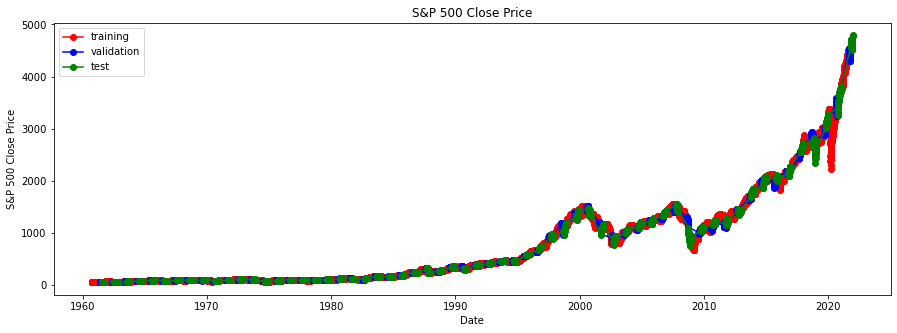

In [133]:
# Visualising training dataset and test dataset

plt.figure(figsize=(15, 5));
plt.plot(date_tr, price_train[:,0], color = 'red', label = 'training', marker= 'o')
plt.plot(date_val, price_val[:,0], color = 'blue', label = 'validation', marker= 'o')
plt.plot(date_tt, price_test[:,0], color = 'green', label = 'test', marker= 'o')
plt.title('S&P 500 Close Price')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.savefig('dataset_full.eps')
plt.show()

### Step 2 - Design and develop RNN in Python, using libraries such as PyTorch (and, if necessary, Tensor Flow). 

In [134]:
hidden_size = 16
num_layers = 1
num_epochs = 100
learning_rate = 0.001

In [136]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [138]:
rnn = Model(input_size, output_size, hidden_size, num_layers)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
rnn

Model(
  (rnn): RNN(1, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

### Step 3 - Training of RNN on Training Set and testing to ensure it functions correctly when predicting the next one, two, three, and four trading data (close price).  

In [139]:
loss1 = []
loss1_val = []
for epoch in range(num_epochs):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(X_tr).float())
    labels = Variable(torch.from_numpy(y_tr).float())
    
    # zero the parameter (weight) gradients
    optimiser.zero_grad()

    # Perform forward pass
    output, hidden = rnn(inputs)   
    
    # Compute loss
    loss = criterion(output.reshape(-1), labels.view(-1))
    loss1 += [loss.item()]
       
    # Backward pass
    loss.backward(retain_graph=True)
       
    #loss for validation
    inputs_val = torch.from_numpy(X_val).float()
    labels_val = torch.from_numpy(y_val).float()
    output_val, hidden_val = rnn(inputs_val)
    loss_val = criterion(output_val.reshape(-1), labels_val.view(-1))
    loss1_val += [loss_val.item()]
    
    if (epoch % 10 == 0 ):
        print("Epoch ", epoch, "MSE: ", loss.item())
    
    # Update parameters
    optimiser.step()                                


Epoch  0 MSE:  0.12477806210517883
Epoch  10 MSE:  0.08003450185060501
Epoch  20 MSE:  0.04812835156917572
Epoch  30 MSE:  0.032808996737003326
Epoch  40 MSE:  0.03172183409333229
Epoch  50 MSE:  0.03000715933740139
Epoch  60 MSE:  0.02818061038851738
Epoch  70 MSE:  0.026741355657577515
Epoch  80 MSE:  0.024951322004199028
Epoch  90 MSE:  0.0229409858584404


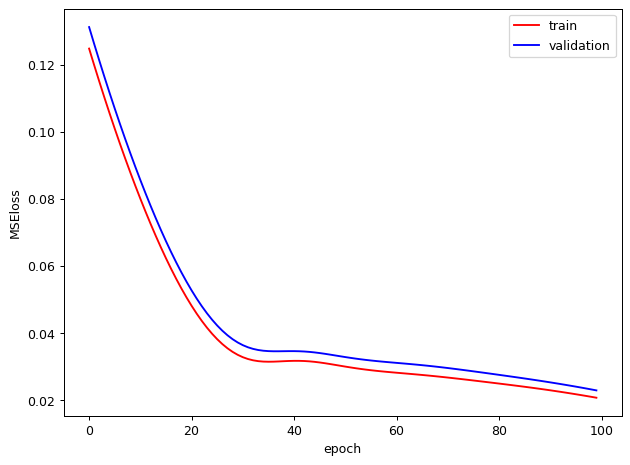

In [140]:
plt.figure(figsize=[8,6], dpi=90)
plt.plot(np.array(loss1), 'r', label = 'train')
plt.plot(np.array(loss1_val), 'b', label = 'validation')
plt.xlabel("epoch")
plt.ylabel("MSEloss")
plt.legend()
plt.savefig('MSEloss1')

In [141]:
print(np.argmin(loss1_val))
print(np.argmin(loss1))

99
99


#### From the plot of MSE loss above, we could see that the MSE of training set and validation set are quite similar. The loss for the validation set keep decrease. Therefore, no overfitting issue. However, based on the prediction plot shown below, there is a significant underfitting issue.

In [143]:
ot = np.concatenate((output.detach().numpy()[:, [0]], 
                           output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]]), axis=1)
ot.shape
pred_price = scaler.inverse_transform(ot)[:, [0]]
pred_price

array([[ 546.17413],
       [ 545.9096 ],
       [ 545.76483],
       ...,
       [2009.8365 ],
       [2007.8766 ],
       [2012.0542 ]], dtype=float32)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


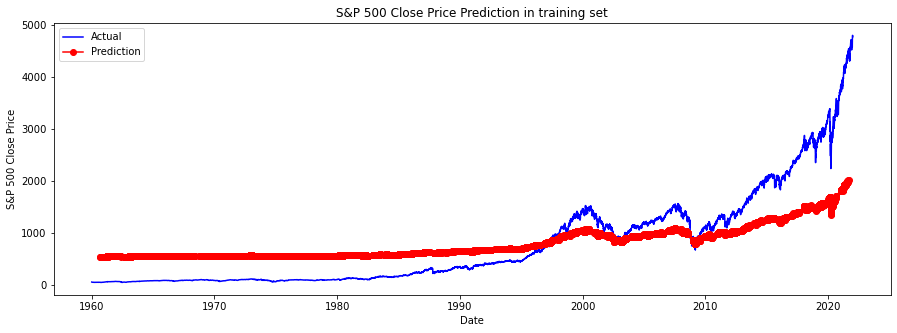

In [144]:
# Visualising the results in training dataset

plt.figure(figsize=(15, 5));
plt.plot(data.Date, dataset[:,0], color = 'blue', label = 'Actual')
plt.plot(date_tr, pred_price, color = 'red', label = 'Prediction', marker = 'o')
plt.title('S&P 500 Close Price Prediction in training set')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.savefig('prediction_1.eps')
plt.show()

### Accuracy will be computed in terms of error defined as pred_error := |pred_price - actual_price| / actual_price 

In [145]:
def pred_error(target, pred):
    error = abs(pred - target)/target
    return error

In [146]:
ot = np.concatenate((y_tr[:, :, 0], y_tr[:, :, 0], y_tr[:, :, 0]), axis = 1)
target_train = scaler.inverse_transform(ot)[:, [0]]
error_train = pred_error(target_train, pred_price)

#### Graph pred_error as a function of timestamp for Training Set. 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


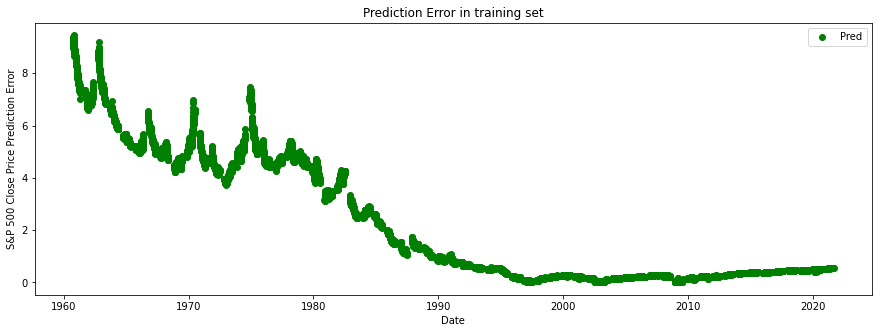

In [147]:
plt.figure(figsize=(15, 5));
plt.plot(date_tr, error_train, color = 'green', label = 'Pred', marker= 'o')
plt.title('Prediction Error in training set')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.savefig('pred_error_1.eps')
plt.show()

### Step 4 - Testing RNN accuracy in predicting the next one, two, three, and four datapoints in the dataset from 1 Jan 1980 through the present day, using a sliding sampling window of width 180 days. 

In [148]:
# predict next one day
test_inputs = Variable(torch.from_numpy(X_tt).float())
output_test, _ = rnn(test_inputs)
ot = np.concatenate((output_test.detach().numpy()[:, [0]], 
                           output_test.detach().numpy()[:, [0]], 
                           output_test.detach().numpy()[:, [0]]), axis=1)
pred_price_test = scaler.inverse_transform(ot)[:, [0]]
pred_price_test

array([[ 543.9612 ],
       [ 543.99835],
       [ 544.0088 ],
       ...,
       [2074.1025 ],
       [2081.361  ],
       [2094.3494 ]], dtype=float32)

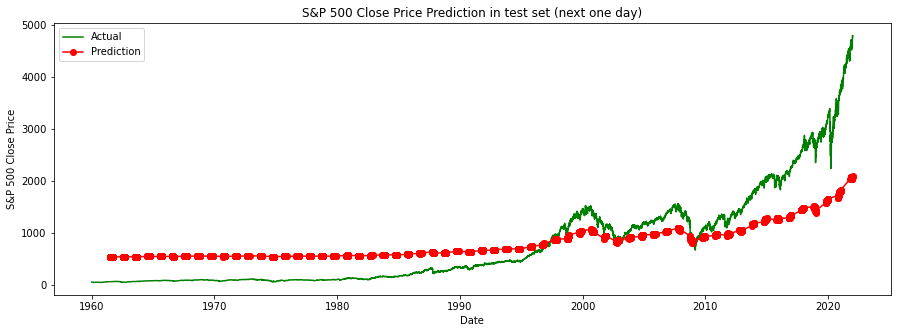

In [152]:
# Visualising the results in test dataset

plt.figure(figsize=(15, 5));
plt.plot(data.Date, dataset[:,0], color = 'green', label = 'Actual')
plt.plot(date_tt,
         pred_price_test, color = 'red', label = 'Prediction', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.show()

In [153]:
ot = np.concatenate( (y_tt[:, :, 0], y_tt[:, :, 0], y_tt[:, :, 0]), axis = 1)
target_test = scaler.inverse_transform(ot)[:, [0]]
error_test = pred_error(target_test, pred_price_test)

#### Graph pred_error as a function of timestamp for Test Set. 

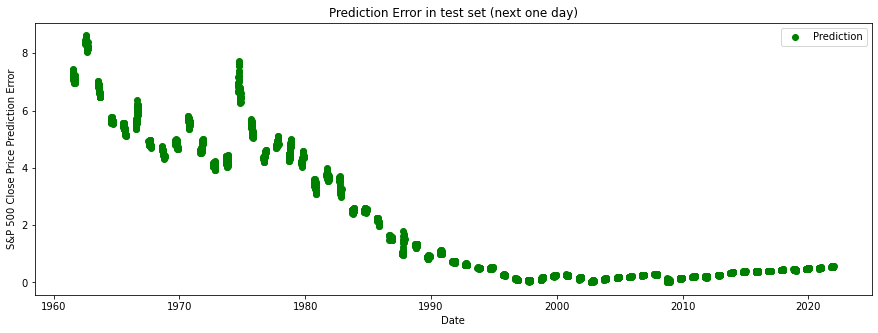

In [154]:
plt.figure(figsize=(15, 5));
plt.plot(date_tt, error_test, color = 'green', label = 'Prediction', marker= 'o')
plt.title('Prediction Error in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [155]:
# predict next two day
test_inputs = Variable(torch.from_numpy(X_tt).float())
output_test, _ = rnn(test_inputs)
ot = np.concatenate((output_test.detach().numpy()[:, [1]], 
                           output_test.detach().numpy()[:, [1]], 
                           output_test.detach().numpy()[:, [1]]), axis=1)
pred_price_test = sc.inverse_transform(ot)[:, [0]]
ot = np.concatenate( (y_tt[:, :, 1], y_tt[:, :, 1], y_tt[:, :, 1]), axis = 1)
target_test = scaler.inverse_transform(ot)[:, [0]]
error_test = pred_error(target_test, pred_price_test)
pred_price_test

array([[ 635.5692],
       [ 635.6134],
       [ 635.6223],
       ...,
       [1726.9209],
       [1735.1317],
       [1744.6416]], dtype=float32)

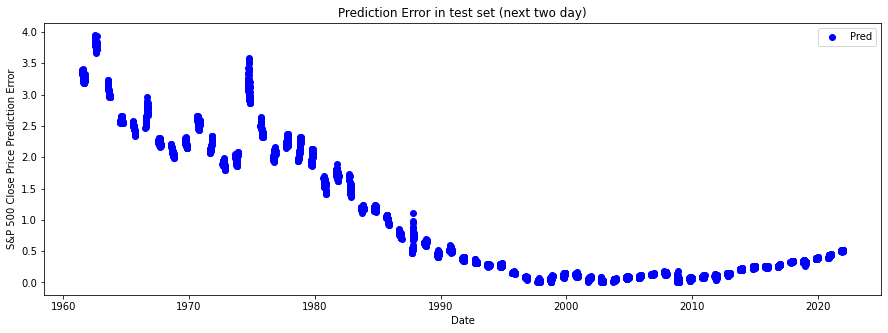

In [47]:
plt.figure(figsize=(15, 5));
plt.plot(date_tt + pd.Timedelta('1 day'), error_test, color = 'green', label = 'Prediction', marker= 'o')
plt.title('Prediction Error in test set (next two day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [48]:
# predict next three day
test_inputs = Variable(torch.from_numpy(X_tt).float())
output_test, _ = rnn(test_inputs)
ot = np.concatenate((output_test.detach().numpy()[:, [2]], 
                           output_test.detach().numpy()[:, [2]], 
                           output_test.detach().numpy()[:, [2]]), axis=1)
pred_price_test = sc.inverse_transform(ot)[:, [0]]
ot = np.concatenate( (y_tt[:, :, 2], y_tt[:, :, 2], y_tt[:, :, 2]), axis = 1)
target_test = sc.inverse_transform(ot)[:, [0]]
error_test = pred_error(target_test, pred_price_test)
pred_price_test

array([[ 129.5652 ],
       [ 129.6711 ],
       [ 129.75255],
       ...,
       [2448.7017 ],
       [2454.1003 ],
       [2463.6714 ]], dtype=float32)

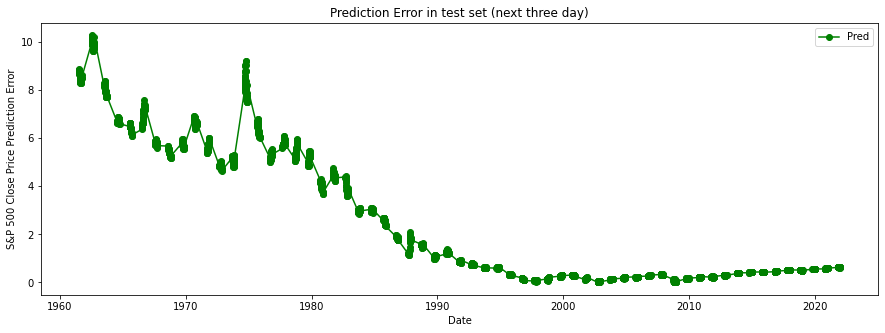

In [156]:
plt.figure(figsize=(15, 5));
plt.plot(date_tt + pd.Timedelta('2 day'), error_test, color = 'green', label = 'Pred', marker= 'o')
plt.title('Prediction Error in test set (next three day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [157]:
# predict next four day
test_inputs = Variable(torch.from_numpy(X_tt).float())
output_test, _ = rnn(test_inputs)
ot = np.concatenate((output_test.detach().numpy()[:, [3]], 
                           output_test.detach().numpy()[:, [3]], 
                           output_test.detach().numpy()[:, [3]]), axis=1)
pred_price_test = scaler.inverse_transform(ot)[:, [0]]
ot = np.concatenate( (y_tt[:, :, 3], y_tt[:, :, 3], y_tt[:, :, 3]), axis = 1)
target_test = sc.inverse_transform(ot)[:, [0]]
error_test = pred_error(target_test, pred_price_test)
pred_price_test

array([[ 668.4113],
       [ 668.4341],
       [ 668.4283],
       ...,
       [1558.9799],
       [1567.3932],
       [1575.7563]], dtype=float32)

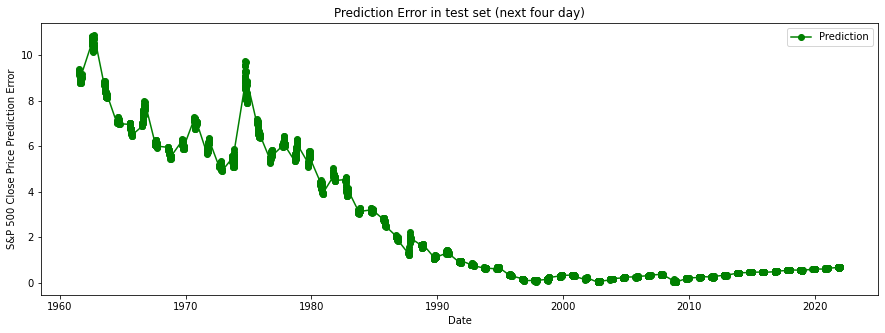

In [158]:
plt.figure(figsize=(15, 5));
plt.plot(date_tt + pd.Timedelta('3 day'), error_test, color = 'green', label = 'Prediction', marker= 'o')
plt.title('Prediction Error in test set (next four day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

### In case we want to only display the result after 1980

In [159]:
dtime = np.datetime64("1980-01-01")
date_tt_partial = date_tt[date_tt>dtime]
error_partial = error_test[date_tt>dtime]

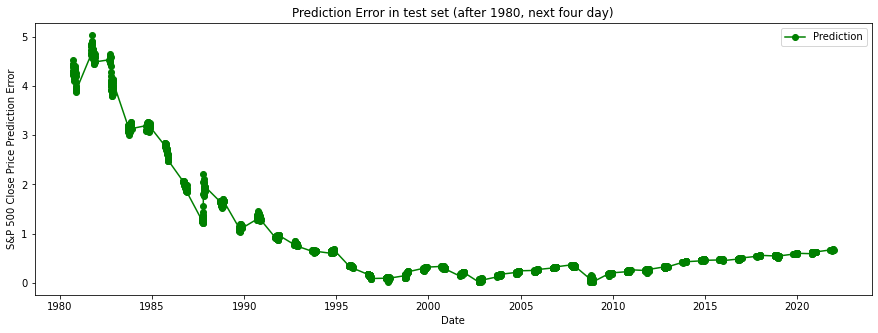

In [160]:
plt.figure(figsize=(15, 5));
plt.plot(date_tt_partial, error_partial, color = 'green', label = 'Prediction', marker= 'o')
plt.title('Prediction Error in test set (after 1980, next four day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

### Step 5 - Optimizing RNN performance to yield maximum achievable accuracy over the entire Training Set and Test Set by reconstructing the training set and test set with no validation set this time

In [161]:
# number of timepoint and number of feature
n_rows, n_cols = dataset_normalized.shape
# Creating a data structure with 180 timesteps and 4 output
X = []
y = []
date_full = []
for i in range( n_rows - sliding_wd_size - output_size +1):
    X.append(dataset_normalized[i:i+sliding_wd_size, ])
    y.append(dataset_normalized[i+sliding_wd_size: i+sliding_wd_size+output_size, 0])
    date_full.append(date_dt[i+sliding_wd_size])
    
X, y, date_full = np.array(X), np.array(y), np.array(date_full)
y = np.reshape(y, (y.shape[0], 1, y.shape[1]))

In [162]:
X_tr = []; y_tr = []; date_tr = []
X_tt = []; y_tt = []; date_tt = []
for i in range(X.shape[0]):
    if(i  %  253 >= 200):
        X_tt.append(X[i])
        y_tt.append(y[i])
        date_tt.append(date_full[i])
    else:
        X_tr.append(X[i])
        y_tr.append(y[i])
        date_tr.append(date_full[i])
X_tr, y_tr, date_tr = np.array(X_tr), np.array(y_tr), np.array(date_tr)          
X_tt, y_tt, date_tt = np.array(X_tt), np.array(y_tt), np.array(date_tt)      

### To overcome the underfitting issue, we increase the number layer from 1 to 2, increase hidden unit size from 8 to 32. In addition, we increase the learning rate from 0.001 to 0.003 to speed up the learning process.

In [163]:
input_size = 1
hidden_size = 32
num_layers = 2
output_size = 4
num_epochs = 100
learning_rate = 0.003
sliding_wd_size = 180

In [164]:
rnn = Model (input_size, output_size, hidden_size, num_layers)
optimiser = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
rnn

Model(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=4, bias=True)
)

In [165]:
for epoch in range(num_epochs):
    # make training sets in torch
    inputs = Variable(torch.from_numpy(X_tr).float())
    labels = Variable(torch.from_numpy(y_tr).float())

    output, hidden = rnn(inputs) 
    
    loss = criterion(output.reshape(-1), labels.view(-1))
    
    if (epoch % 10 == 0 ):
        print("Epoch ", epoch, "MSE: ", loss.item())
    optimiser.zero_grad()

    # Backward pass
    loss.backward(retain_graph=True)

    # Update parameters
    optimiser.step()        

Epoch  0 MSE:  0.09643027186393738
Epoch  10 MSE:  0.031611647456884384
Epoch  20 MSE:  0.017994839698076248
Epoch  30 MSE:  0.0020495038479566574
Epoch  40 MSE:  0.0011716282460838556
Epoch  50 MSE:  0.0006042849272489548
Epoch  60 MSE:  0.0004093251482117921
Epoch  70 MSE:  0.00031357177067548037
Epoch  80 MSE:  0.00024417764507234097
Epoch  90 MSE:  0.0001947510172612965


In [167]:
ot = np.concatenate((output.detach().numpy()[:, [0]], 
                           output.detach().numpy()[:, [0]],
                           output.detach().numpy()[:, [0]]), axis=1)
ot.shape
pred_price = sc.inverse_transform(ot)[:, [0]]
pred_price
ot = np.concatenate( (y_tr[:, :, 0], y_tr[:, :, 0], y_tr[:, :, 0]), axis = 1)
target_train = sc.inverse_transform(ot)[:, [0]]
error_train = pred_error(target_train, pred_price)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


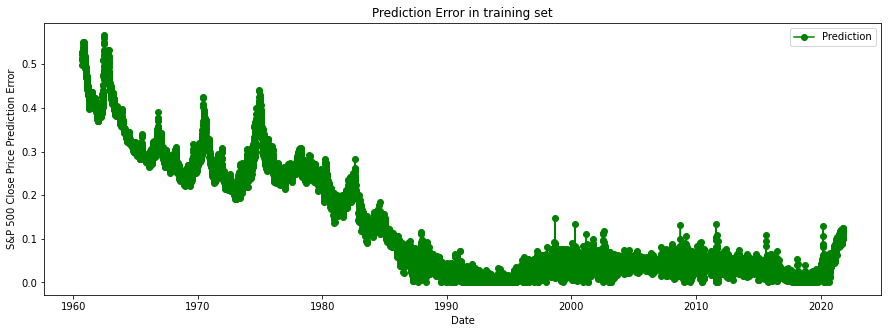

In [168]:
plt.figure(figsize=(15, 5));
plt.plot(date_tr, error_train, color = 'green', label = 'Prediction', marker= 'o')
plt.title('Prediction Error in training set')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.savefig('pred_error_2.eps')
plt.show()

In [169]:
#predict next one day (index2 = 0)
index2 = 0
test_inputs = Variable(torch.from_numpy(X_tt).float())
output_test, _ = rnn(test_inputs)
ot = np.concatenate((output_test.detach().numpy()[:, [index2]], 
                           output_test.detach().numpy()[:, [index2]], 
                           output_test.detach().numpy()[:, [index2]]), axis=1)
pred_price_test = scaler.inverse_transform(ot)[:, [0]]
pred_price_test

array([[  38.428314],
       [  38.75328 ],
       [  38.875732],
       ...,
       [4054.0488  ],
       [4076.0227  ],
       [4103.778   ]], dtype=float32)

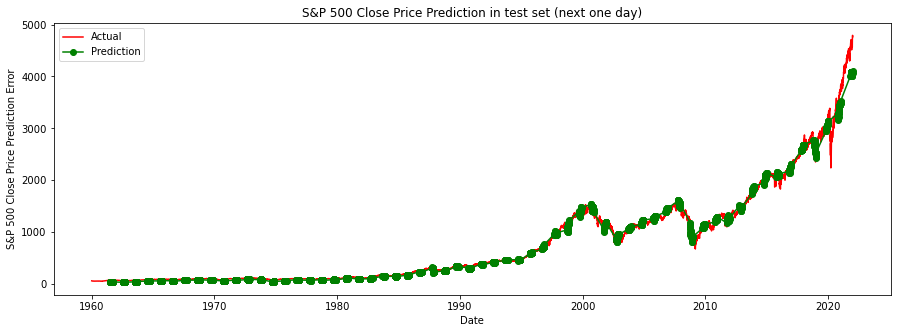

In [171]:
# Visualising the results in test dataset
plt.figure(figsize=(15, 5));
plt.plot(data.Date, dataset[:,0], color = 'red', label = 'Actual')
plt.plot(date_tt,pred_price_test, color = 'green', label = 'Prediction', marker='o')
plt.title('S&P 500 Close Price Prediction in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [172]:
ot = np.concatenate( (y_tt[:, :, index2], y_tt[:, :, index2], y_tt[:, :, index2]), axis = 1)
target_test = sc.inverse_transform(ot)[:, [0]]
error_test = pred_error(target_test, pred_price_test)

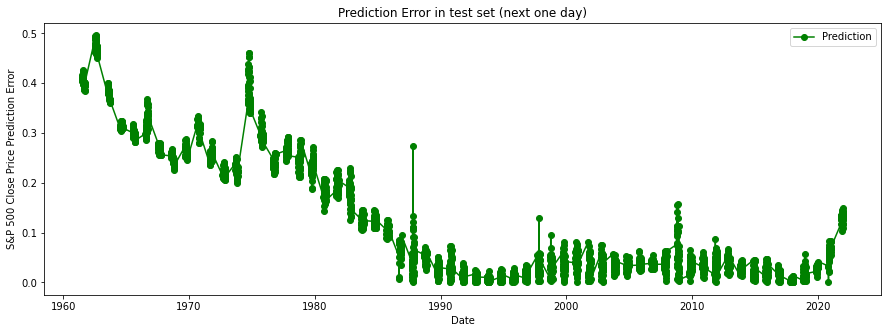

In [173]:
plt.figure(figsize=(15, 5));
plt.plot(date_tt, error_test, color = 'green', label = 'Prediction', marker= 'o')
plt.title('Prediction Error in test set (next one day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [174]:
#predict next two day (index2 = 1)
index2 = 1
test_inputs = Variable(torch.from_numpy(X_tt).float())
output_test, _ = rnn(test_inputs)
ot = np.concatenate((output_test.detach().numpy()[:, [index2]], 
                           output_test.detach().numpy()[:, [index2]], 
                           output_test.detach().numpy()[:, [index2]]), axis=1)
pred_price_test = sc.inverse_transform(ot)[:, [0]]
ot = np.concatenate( (y_tt[:, :, index2], y_tt[:, :, index2], y_tt[:, :, index2]), axis = 1)
target_test = sc.inverse_transform(ot)[:, [0]]
error_test = pred_error(target_test, pred_price_test)

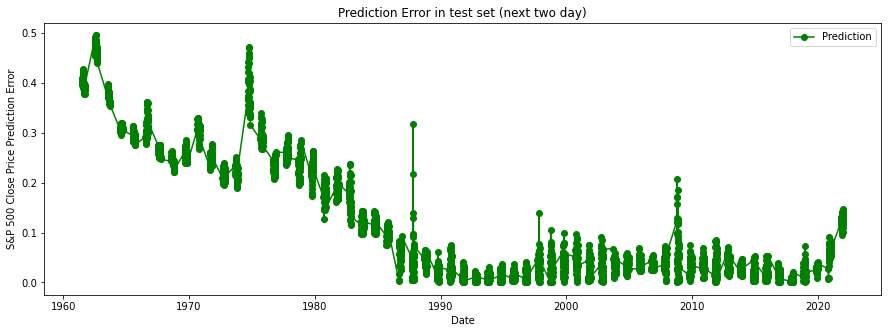

In [175]:
plt.figure(figsize=(15, 5));
plt.plot(date_tt + pd.Timedelta('1 day'), error_test, color = 'green', label = 'Prediction', marker= 'o')
plt.title('Prediction Error in test set (next two day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [176]:
#predict next three day (index2 = 2)
index2 = 2
test_inputs = Variable(torch.from_numpy(X_tt).float())
output_test, _ = rnn(test_inputs)
ot = np.concatenate((output_test.detach().numpy()[:, [index2]], 
                           output_test.detach().numpy()[:, [index2]], 
                           output_test.detach().numpy()[:, [index2]]), axis=1)
pred_price_test = sc.inverse_transform(ot)[:, [0]]
ot = np.concatenate( (y_tt[:, :, index2], y_tt[:, :, index2], y_tt[:, :, index2]), axis = 1)
target_test = sc.inverse_transform(ot)[:, [0]]
error_test = pred_error(target_test, pred_price_test)

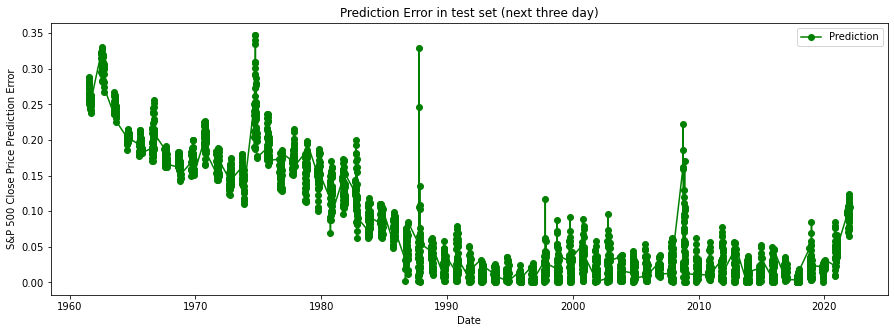

In [177]:
plt.figure(figsize=(15, 5));
plt.plot(date_tt + pd.Timedelta('2 day'), error_test, color = 'green', label = 'Prediction', marker= 'o')
plt.title('Prediction Error in test set (next three day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

In [178]:
#predict next four day (index2 = 3)
index2 = 3
test_inputs = Variable(torch.from_numpy(X_tt).float())
output_test, _ = rnn(test_inputs)
ot = np.concatenate((output_test.detach().numpy()[:, [index2]], 
                           output_test.detach().numpy()[:, [index2]], 
                           output_test.detach().numpy()[:, [index2]]), axis=1)
pred_price_test = sc.inverse_transform(ot)[:, [0]]
ot = np.concatenate( (y_tt[:, :, index2], y_tt[:, :, index2], y_tt[:, :, index2]), axis = 1)
target_test = sc.inverse_transform(ot)[:, [0]]
error_test = pred_error(target_test, pred_price_test)

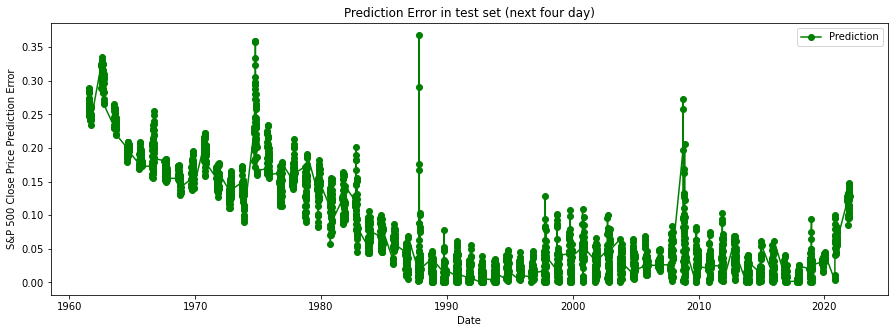

In [179]:
plt.figure(figsize=(15, 5));
plt.plot(date_tt + pd.Timedelta('3 day'), error_test, color = 'green', label = 'Prediction', marker= 'o')
plt.title('Prediction Error in test set (next four day)')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price Prediction Error')
plt.legend()
plt.show()

### Step 6 - Adding noise

In [187]:
# standard deviation
sd = [0.0, 0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
def NoiseData(dataset, sigma):
    dataset_noise = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(len(dataset)):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(sliding_wd_size)), 18)
        dataset_noise[i] = dataset[i]    
        dataset_noise[i, index, 0] = dataset_noise[i, index, 0] + s
    return dataset_noise   

In [188]:
#predict next day (index2 = 0)
index2 = 0
ot = np.concatenate( (y_tt[:, :, index2], y_tt[:, :, index2], y_tt[:, :, index2]), axis = 1)
target_test = sc.inverse_transform(ot)[:, [0]]
error_res_all = []
for sigma in sd:
    dataset_test_noise = NoiseData(X_tt, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    ot = np.concatenate((output_test.detach().numpy()[:, [index2]], 
                               output_test.detach().numpy()[:, [index2]],  
                               output_test.detach().numpy()[:, [index2]]), axis=1)
    pred_price_test = sc.inverse_transform(ot)[:, [0]]
    error = pred_error(target_test, pred_price_test)
    error_res_all.append(error.reshape(-1))

In [189]:
labels = date_tt[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-07,0.415717,0.416029,0.415956,0.415594,0.415124,0.415491,0.415548,0.418384,0.412025,0.412857
1961-07-10,0.410238,0.409148,0.305718,0.607583,0.348587,0.591615,0.280046,0.369158,0.915342,3.971183
1961-07-11,0.408194,0.405424,0.397784,0.414182,0.425306,0.458767,0.545206,0.289896,0.703866,0.351839
1961-07-12,0.405252,0.407094,0.406691,0.404176,0.411628,0.379338,0.376500,0.352725,0.453657,0.437054
1961-07-13,0.403735,0.377410,0.395766,0.395455,0.256642,0.548432,0.626117,0.464673,0.264956,0.124766
...,...,...,...,...,...,...,...,...,...,...
2021-12-21,0.129428,0.129252,0.129802,0.129488,0.129409,0.129451,0.125155,0.126841,0.121953,0.138904
2021-12-22,0.139670,0.139868,0.139890,0.140112,0.140472,0.140245,0.140062,0.139529,0.146044,0.119206
2021-12-23,0.142144,0.142097,0.141955,0.142584,0.142102,0.142683,0.140216,0.138214,0.138441,0.123557
2021-12-27,0.149267,0.149256,0.149213,0.149269,0.149214,0.149421,0.149212,0.148567,0.149548,0.149376


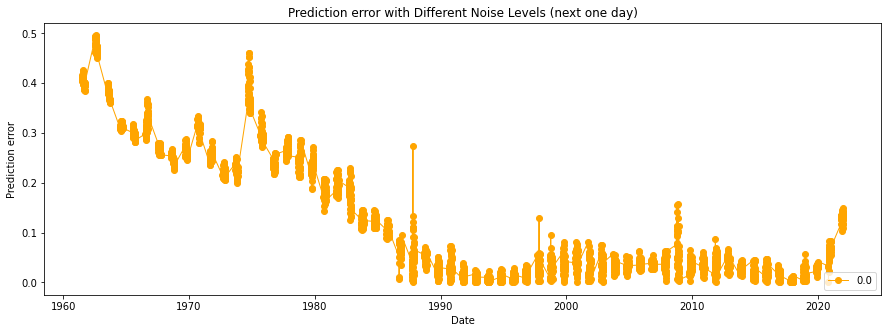

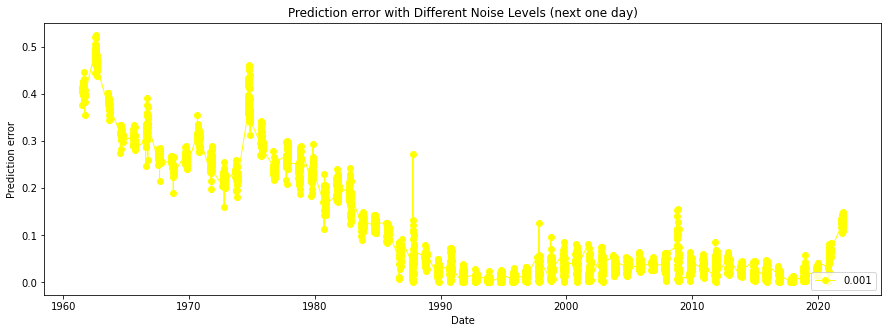

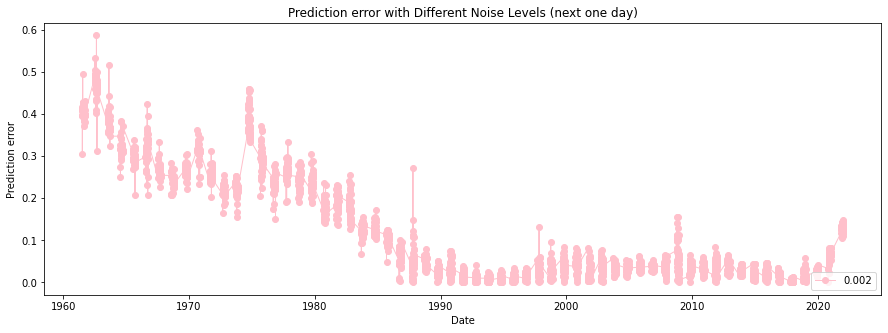

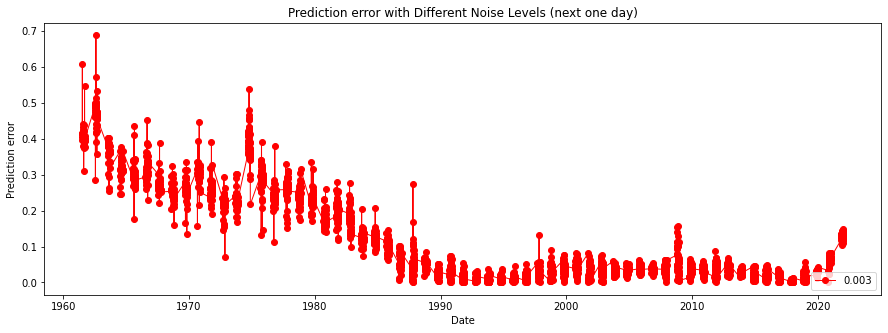

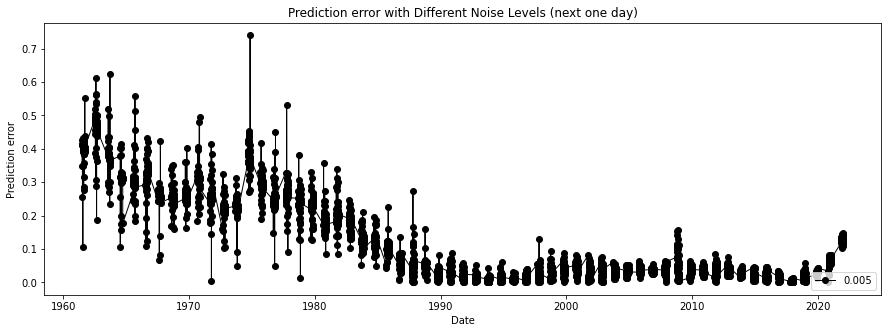

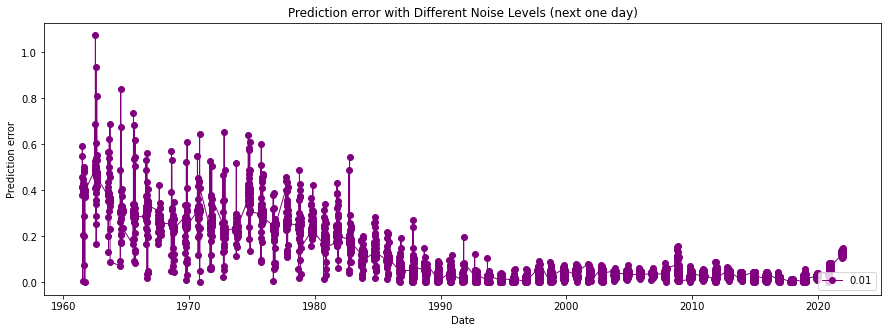

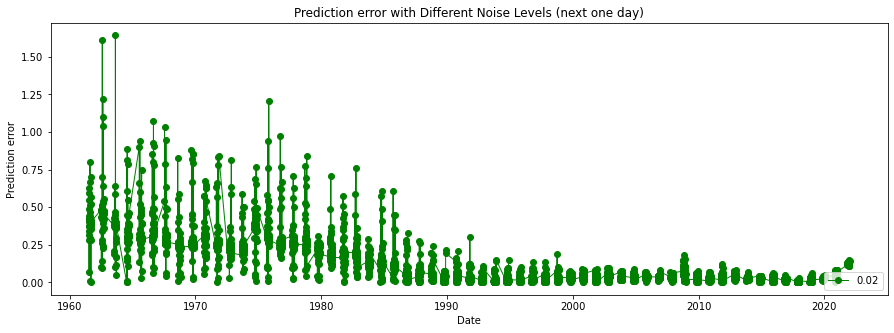

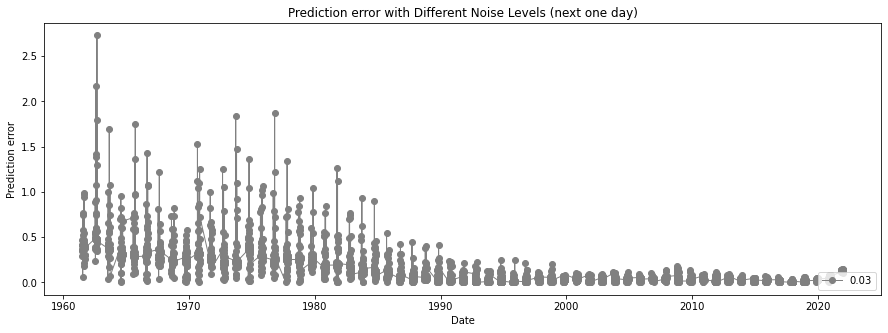

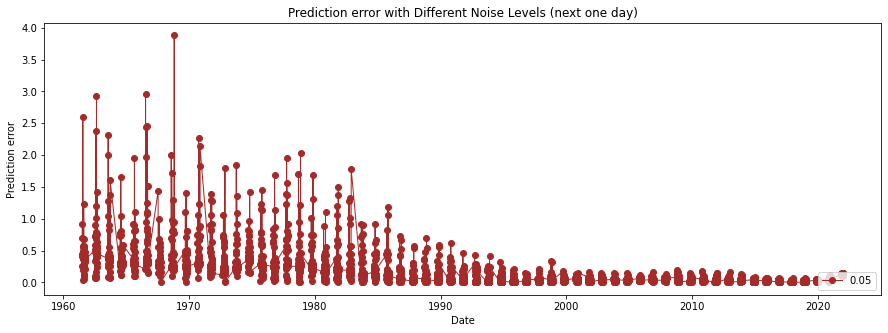

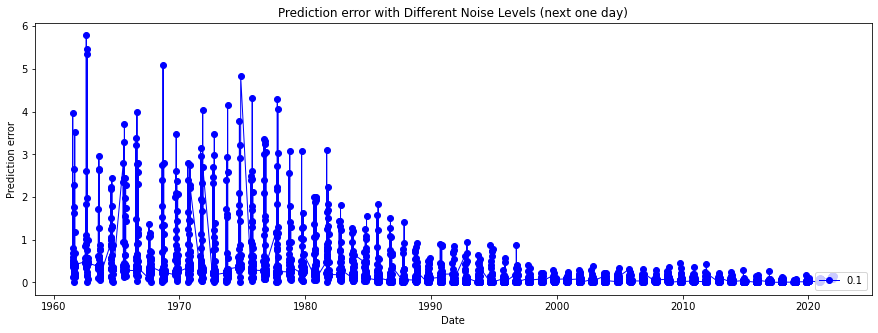

In [190]:
cmaps= [ 'orange',  'yellow', 'pink','red', 'black','purple', 'green', 'grey', 'brown','blue' ]
for i in range(len(sd)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_tt, error_res_all[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next one day)')
    plt.legend(loc="lower right")  
    plt.show()

In [191]:
#predict next two day (index2 = 1)
index2 = 1
ot = np.concatenate( (y_tt[:, :, index2], y_tt[:, :, index2], y_tt[:, :, index2]), axis = 1)
target_test = sc.inverse_transform(ot)[:, [0]]
error_res_all = []
for sigma in sd:
    dataset_test_noise = NoiseData(X_tt, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    ot = np.concatenate((output_test.detach().numpy()[:, [index2]], 
                               output_test.detach().numpy()[:, [index2]],  
                               output_test.detach().numpy()[:, [index2]]), axis=1)
    pred_price_test = sc.inverse_transform(ot)[:, [0]]
    error = pred_error(target_test, pred_price_test)
    error_res_all.append(error.reshape(-1))

In [192]:
temp = date_tt + pd.Timedelta('1 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-08,0.410252,0.410259,0.409783,0.409703,0.411937,0.409563,0.413723,0.406693,0.409020,0.380868
1961-07-11,0.405193,0.399320,0.456093,0.515601,0.496453,0.578934,0.313683,0.301327,0.839941,5.955050
1961-07-12,0.399987,0.399737,0.395404,0.388345,0.411865,0.381121,0.337620,0.429933,0.275694,0.883223
1961-07-13,0.396087,0.396687,0.394734,0.400524,0.397199,0.409967,0.411543,0.400810,0.356925,0.387346
1961-07-14,0.402505,0.429504,0.390609,0.493496,0.375708,0.482518,0.316229,0.677899,0.161600,0.754558
...,...,...,...,...,...,...,...,...,...,...
2021-12-22,0.132014,0.131812,0.132233,0.132137,0.131416,0.130993,0.135372,0.136679,0.138291,0.152529
2021-12-23,0.139146,0.139265,0.138876,0.139004,0.140094,0.140668,0.138200,0.144791,0.138677,0.124691
2021-12-24,0.147509,0.147517,0.147844,0.147398,0.146642,0.147074,0.152817,0.152208,0.151078,0.156561
2021-12-28,0.141886,0.141897,0.141892,0.141870,0.141873,0.141931,0.142089,0.142123,0.141929,0.139408


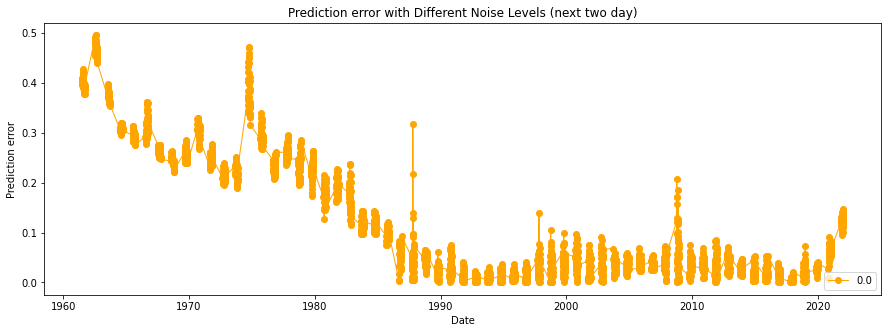

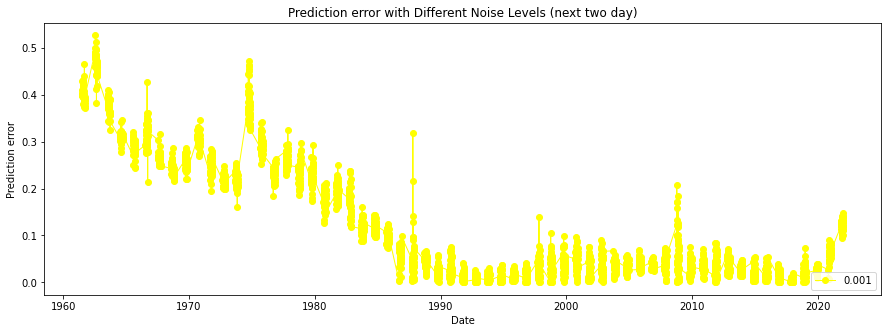

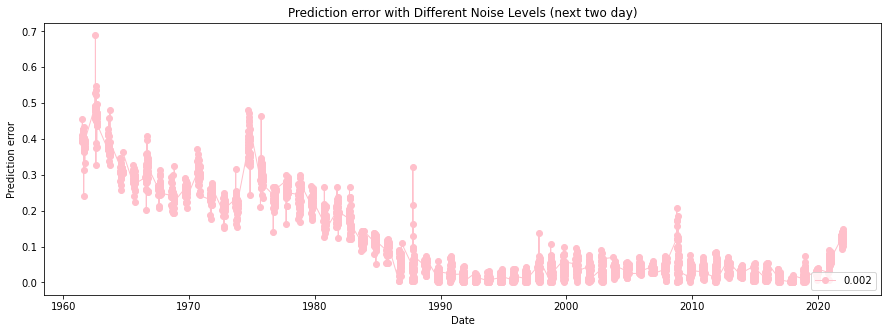

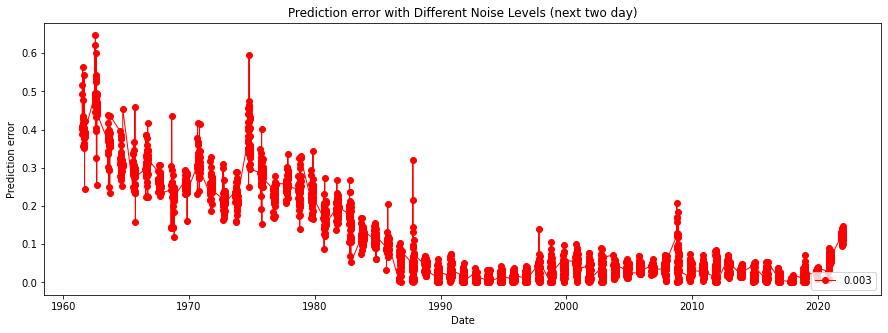

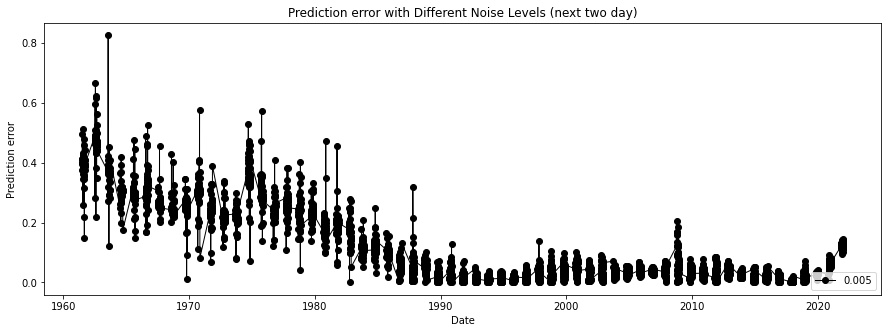

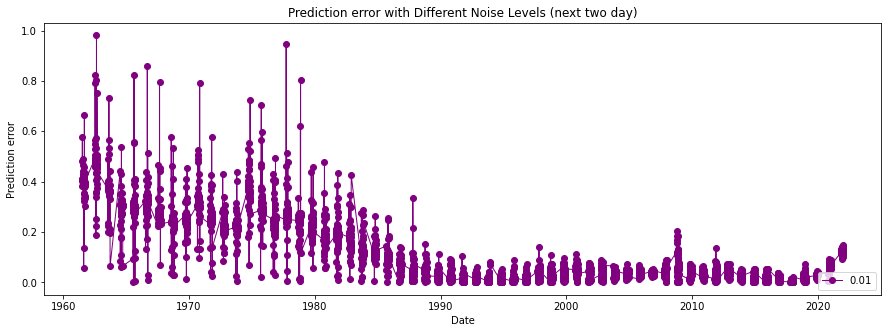

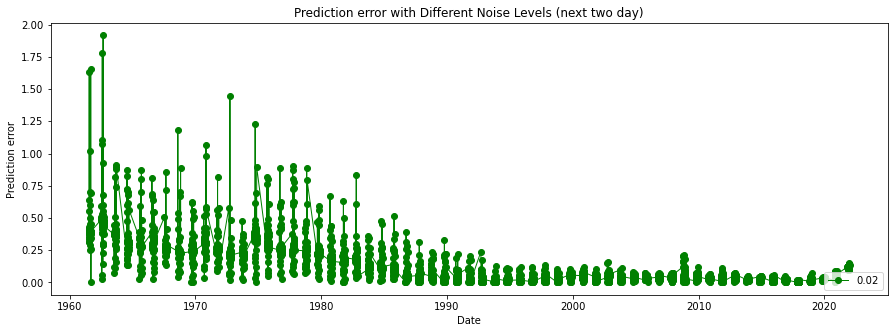

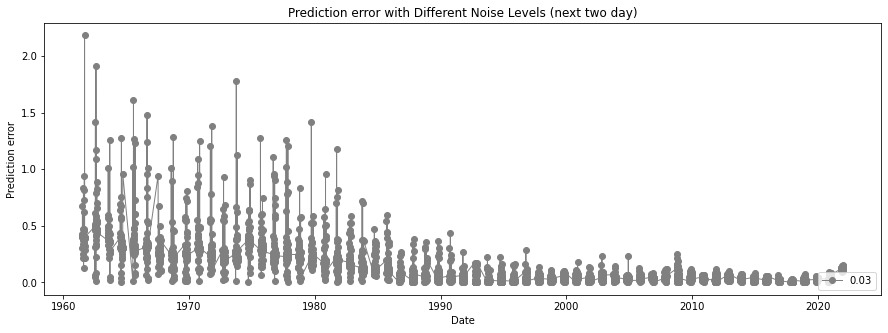

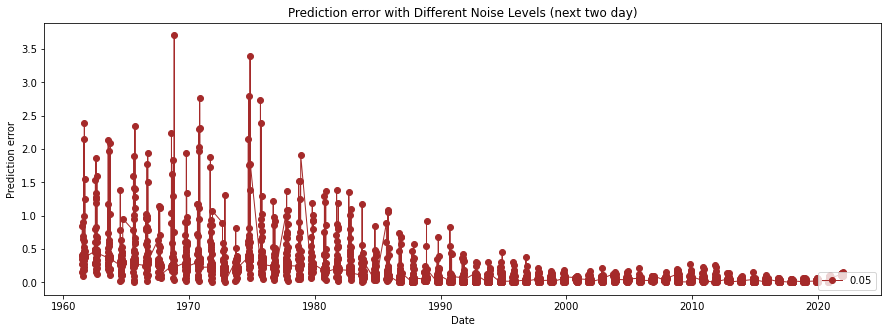

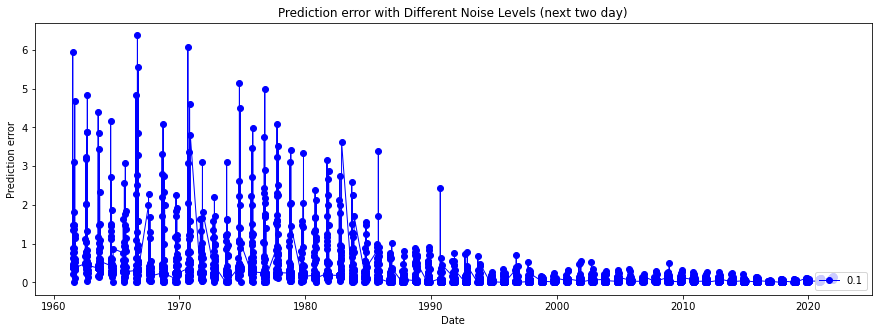

In [193]:
for i in range(len(sd)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_tt+ pd.Timedelta('1 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next two day)')
    plt.legend(loc="lower right")  
    plt.show()

In [194]:
#predict next three day (index2 = 2)
index2 = 2
ot = np.concatenate( (y_tt[:, :, index2], y_tt[:, :, index2], y_tt[:, :, index2]), axis = 1)
target_test = sc.inverse_transform(ot)[:, [0]]
error_res_all = []
for sigma in sd:
    dataset_test_noise = NoiseData(X_tt, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    ot = np.concatenate((output_test.detach().numpy()[:, [index2]], 
                               output_test.detach().numpy()[:, [index2]],  
                               output_test.detach().numpy()[:, [index2]]), axis=1)
    pred_price_test = sc.inverse_transform(ot)[:, [0]]
    error = pred_error(target_test, pred_price_test)
    error_res_all.append(error.reshape(-1))

In [195]:
temp = date_tt + pd.Timedelta('2 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-09,0.266236,0.266190,0.266135,0.266184,0.265042,0.265487,0.273369,0.268887,0.262140,0.257728
1961-07-12,0.257666,0.275542,0.279758,0.137019,0.170955,0.570176,0.299520,0.633686,1.563569,1.478296
1961-07-13,0.250933,0.244595,0.251793,0.239996,0.248780,0.212080,0.301634,0.348250,0.034262,0.748543
1961-07-14,0.256575,0.257194,0.257610,0.259074,0.261297,0.263398,0.275441,0.309150,0.315847,0.089328
1961-07-15,0.254593,0.253617,0.235942,0.162596,0.236478,0.119234,0.328297,0.664557,1.390123,0.195487
...,...,...,...,...,...,...,...,...,...,...
2021-12-23,0.111741,0.111652,0.112091,0.111114,0.111292,0.111924,0.101012,0.111848,0.123385,0.077558
2021-12-24,0.124093,0.124076,0.124281,0.123163,0.124204,0.121581,0.123338,0.118259,0.126202,0.137391
2021-12-25,0.120642,0.120805,0.121069,0.120435,0.118060,0.122045,0.111656,0.117243,0.120905,0.086008
2021-12-29,0.116633,0.116617,0.116645,0.116676,0.116639,0.116828,0.116819,0.116481,0.116687,0.117026


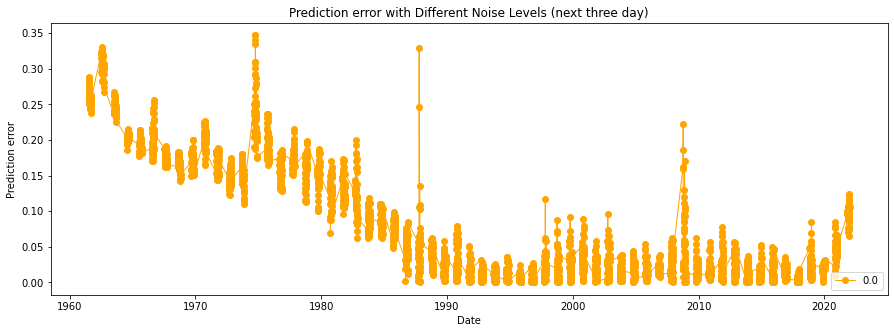

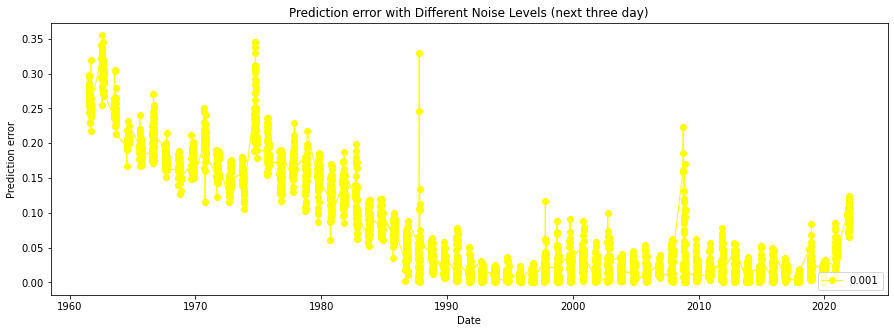

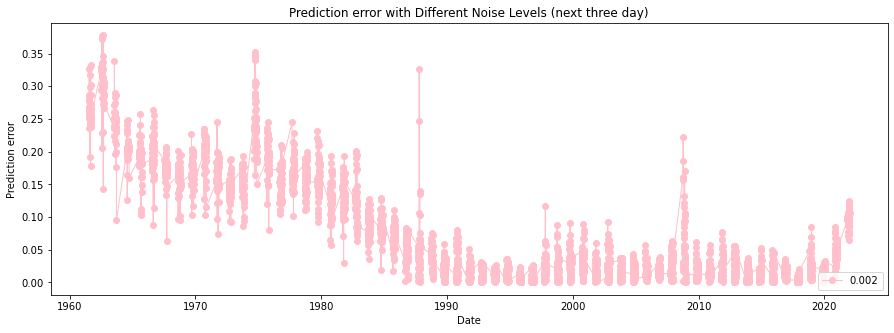

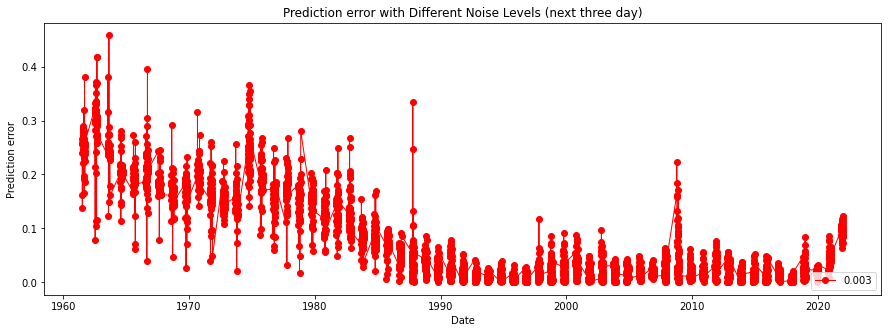

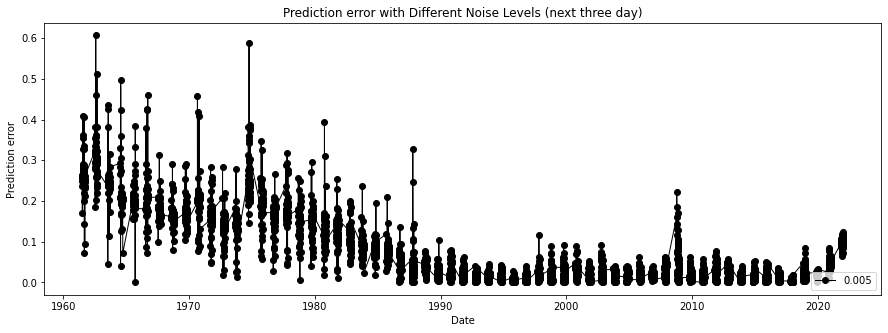

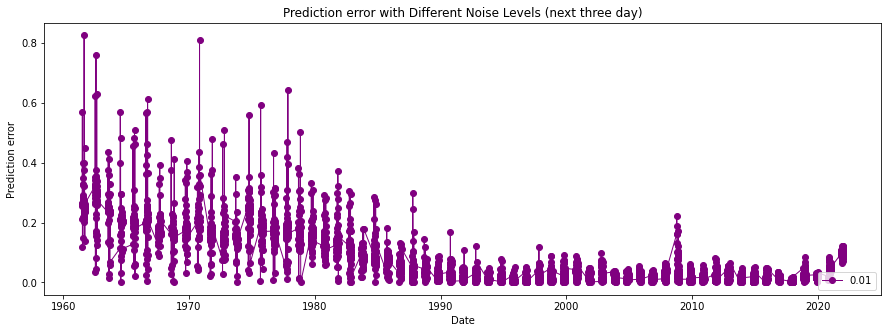

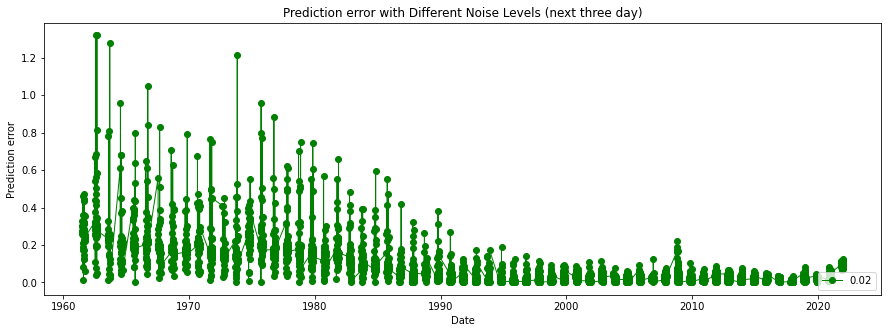

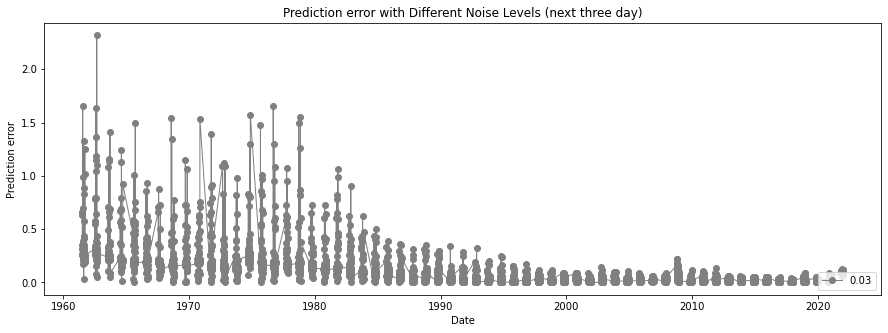

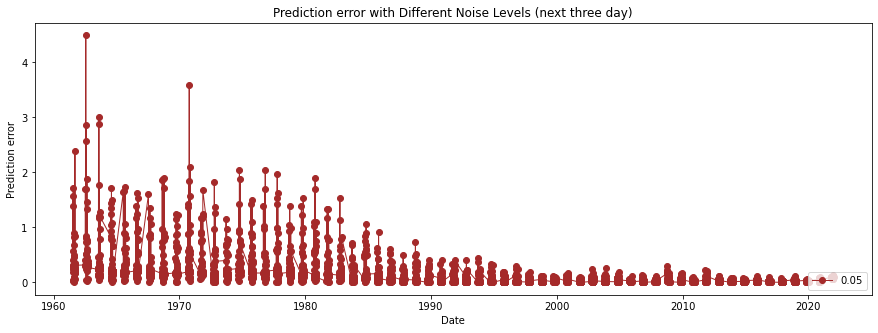

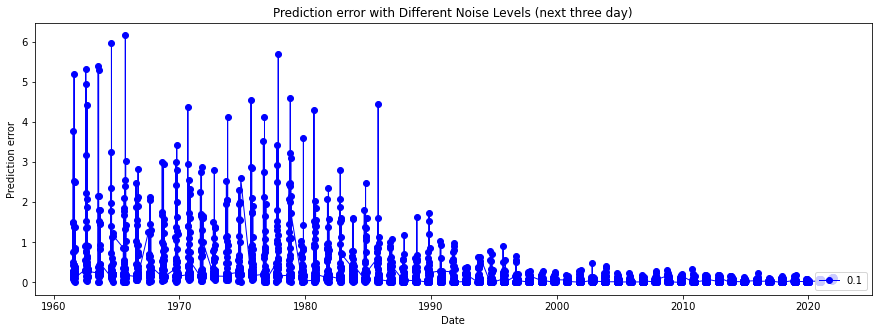

In [196]:
for i in range(len(sd)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_tt+ pd.Timedelta('2 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next three day)')
    plt.legend(loc="lower right")  
    plt.show()

In [197]:
#predict next four day (index2 = 3)
index2 = 3
ot = np.concatenate( (y_tt[:, :, index2], y_tt[:, :, index2], y_tt[:, :, index2]), axis = 1)
target_test = sc.inverse_transform(ot)[:, [0]]
error_res_all = []
for sigma in sd:
    dataset_test_noise = NoiseData(X_tt, sigma)
    test_inputs = Variable(torch.from_numpy(dataset_test_noise).float())
    output_test, _ = rnn(test_inputs)
    ot = np.concatenate((output_test.detach().numpy()[:, [index2]], 
                               output_test.detach().numpy()[:, [index2]],  
                               output_test.detach().numpy()[:, [index2]]), axis=1)
    pred_price_test = sc.inverse_transform(ot)[:, [0]]
    error = pred_error(target_test, pred_price_test)
    error_res_all.append(error.reshape(-1))

In [198]:
temp = date_tt + pd.Timedelta('3 day')
labels = temp[:,0]
error_df=pd.DataFrame(error_res_all, columns=labels, index=sd).T
error_df

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
1961-07-10,0.260741,0.260860,0.261046,0.260998,0.262602,0.262214,0.259679,0.261541,0.261273,0.262282
1961-07-13,0.251244,0.220819,0.275270,0.184436,0.162567,0.020858,0.787619,1.019813,0.994667,4.947416
1961-07-14,0.254586,0.253435,0.257854,0.253054,0.273190,0.336284,0.192307,0.428209,0.012326,0.060500
1961-07-15,0.249473,0.251104,0.249919,0.249028,0.251860,0.253020,0.266128,0.253457,0.176115,0.416914
1961-07-16,0.248163,0.290157,0.192078,0.157946,0.340474,0.159968,0.156970,1.411771,0.747893,2.173364
...,...,...,...,...,...,...,...,...,...,...
2021-12-24,0.147790,0.147516,0.147824,0.147755,0.146647,0.145903,0.147235,0.140305,0.155839,0.154901
2021-12-25,0.146852,0.146775,0.146873,0.147477,0.147853,0.143828,0.147067,0.149781,0.156042,0.137376
2021-12-26,0.144621,0.144593,0.144842,0.144028,0.146039,0.143588,0.150466,0.136853,0.146131,0.155869
2021-12-30,0.137170,0.137168,0.137186,0.137158,0.137249,0.137308,0.137276,0.137005,0.137961,0.139781


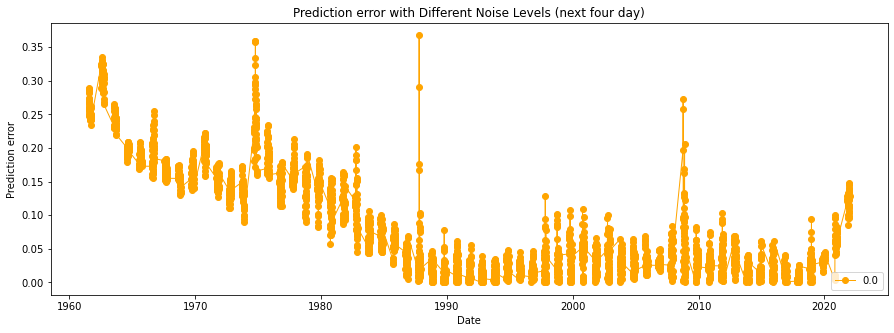

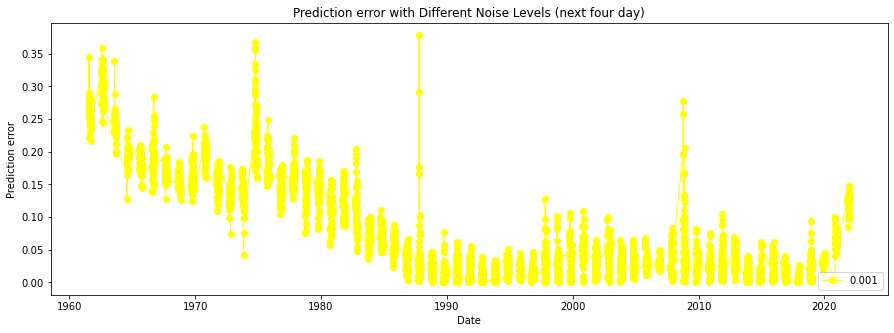

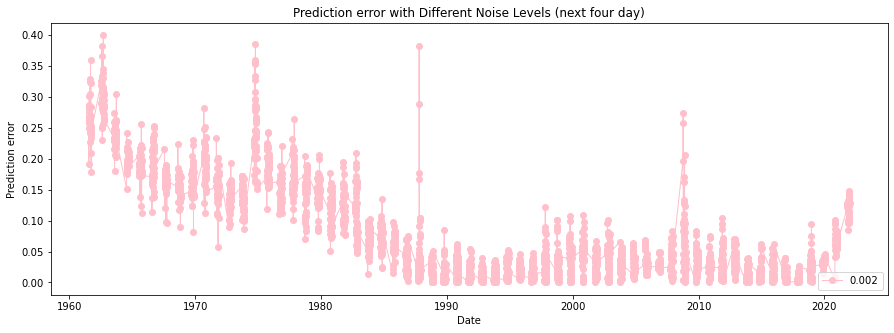

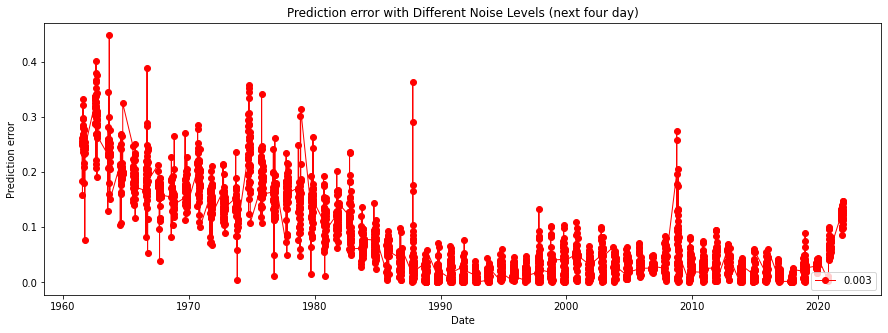

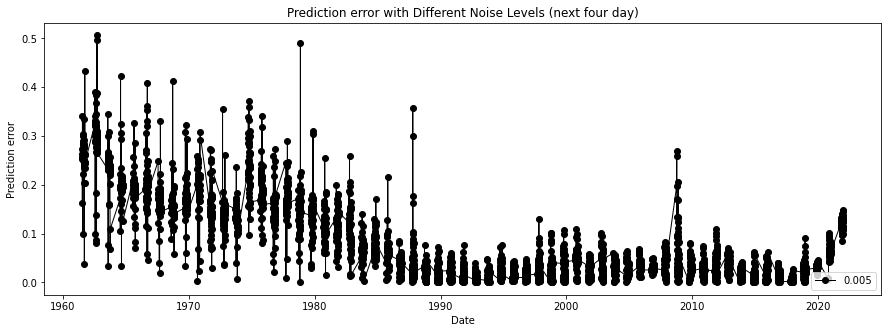

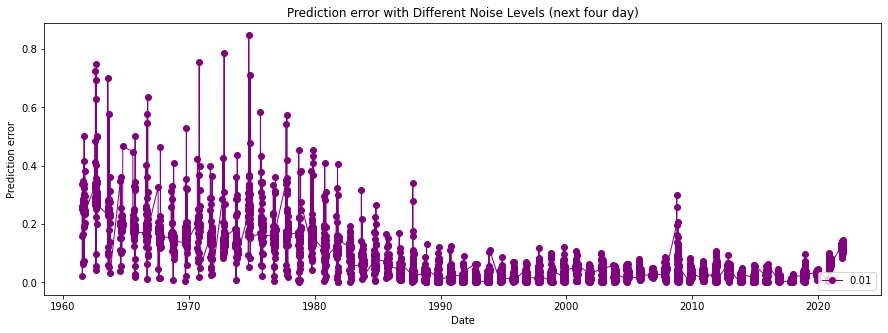

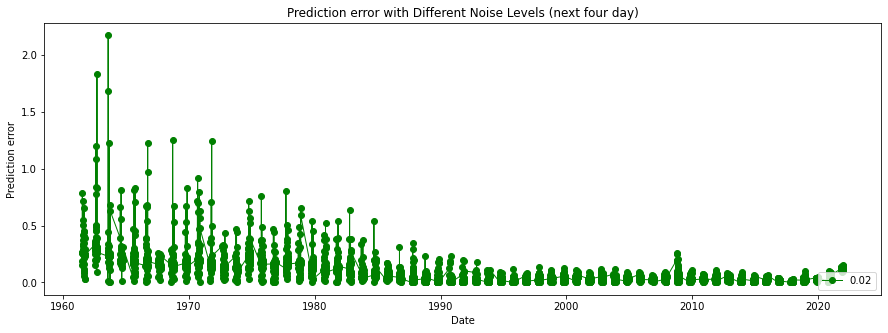

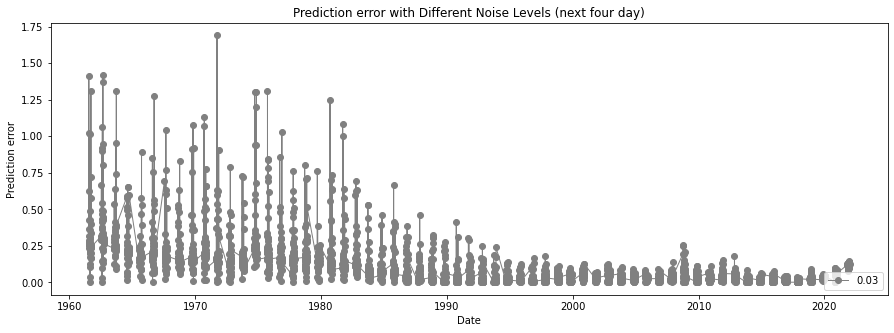

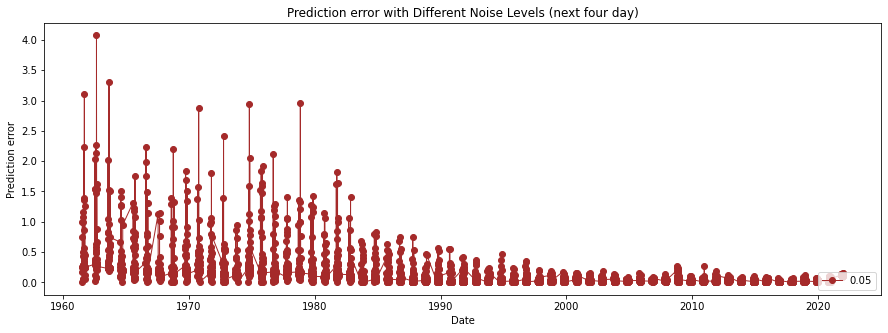

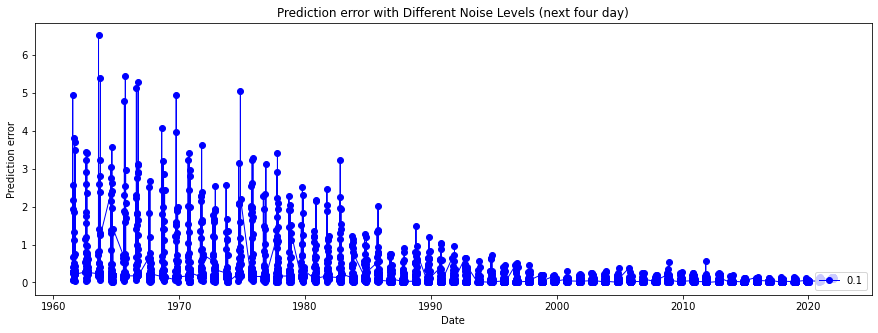

In [199]:
for i in range(len(sd)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(date_tt+ pd.Timedelta('3 day'), error_res_all[i], color=cmaps[i], lw=1, label = sd[i], marker= 'o')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next four day)')
    plt.legend(loc="lower right")  
    plt.show()